In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pysindy as ps
from scipy.integrate import solve_ivp
from scipy.ndimage import gaussian_filter1d
from scipy.integrate import cumtrapz

import os

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from pysindy.feature_library import FourierLibrary
from pysindy.feature_library import CustomLibrary
from pysindy.feature_library import PolynomialLibrary

from pysindy.optimizers import SR3
from pysindy.optimizers import ConstrainedSR3
#import sdeint

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [8]:
data = pd.read_pickle("C:/1. Power grid frequency data/df_South_Korea_cleansed_2024-08-15_2024-12-10.pkl")

data.index = pd.to_datetime(data.index)

# Step 1: Filter for rows where QI == 0 and no NaN in any relevant column
data_filtered = data[(data['QI'] == 0) & (data['freq'].notna())].dropna()

# Recheck for NaN
print("NaN Summary after filtering for QI and freq in data_filtered:")
print(data_filtered.isna().sum())

# Step 2: Group the data by the hour
hourly_groups = data_filtered.groupby(data_filtered.index.floor('H'))

# Step 3: Filter out incomplete hours 
valid_hours = hourly_groups.filter(lambda x: len(x) == 3600)

# Step 4: Extract the 'freq' column and add a 'Time' column
valid_hours['Time'] = valid_hours.index  #
freq = valid_hours['freq']

# Validate that valid_hours is a multiple of 3600
print(f"Total rows in valid_hours: {len(valid_hours)}")
print(f"Is valid_hours a multiple of 3600? {len(valid_hours) % 3600 == 0}")


NaN Summary after filtering for QI and freq in data_filtered:
freq    0
QI      0
dtype: int64


C:\Users\wp7528\AppData\Local\Temp\ipykernel_2816\1879534582.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_groups = data_filtered.groupby(data_filtered.index.floor('H'))


Total rows in valid_hours: 8823600
Is valid_hours a multiple of 3600? True


In [9]:
# Look the first 10 rows of valid_hours
print(valid_hours.head(10))


                          freq QI                Time
2024-08-15 01:00:00  59.974473  0 2024-08-15 01:00:00
2024-08-15 01:00:01  59.975651  0 2024-08-15 01:00:01
2024-08-15 01:00:02  59.977579  0 2024-08-15 01:00:02
2024-08-15 01:00:03  59.976437  0 2024-08-15 01:00:03
2024-08-15 01:00:04  59.974978  0 2024-08-15 01:00:04
2024-08-15 01:00:05  59.973959  0 2024-08-15 01:00:05
2024-08-15 01:00:06  59.977355  0 2024-08-15 01:00:06
2024-08-15 01:00:07  59.976714  0 2024-08-15 01:00:07
2024-08-15 01:00:08  59.977276  0 2024-08-15 01:00:08
2024-08-15 01:00:09  59.978177  0 2024-08-15 01:00:09


In [10]:
# Delete QI column and convert frequency to omega and add 'omega' column
valid_hours.drop(columns=['QI'], inplace=True)
valid_hours['omega'] = 2 * np.pi * (valid_hours['freq'] - 60)

# Look the first 10 rows of valid_hours
print(valid_hours.head(10))
len(valid_hours)/3600

                          freq                Time     omega
2024-08-15 01:00:00  59.974473 2024-08-15 01:00:00 -0.160393
2024-08-15 01:00:01  59.975651 2024-08-15 01:00:01 -0.152990
2024-08-15 01:00:02  59.977579 2024-08-15 01:00:02 -0.140874
2024-08-15 01:00:03  59.976437 2024-08-15 01:00:03 -0.148052
2024-08-15 01:00:04  59.974978 2024-08-15 01:00:04 -0.157216
2024-08-15 01:00:05  59.973959 2024-08-15 01:00:05 -0.163623
2024-08-15 01:00:06  59.977355 2024-08-15 01:00:06 -0.142285
2024-08-15 01:00:07  59.976714 2024-08-15 01:00:07 -0.146311
2024-08-15 01:00:08  59.977276 2024-08-15 01:00:08 -0.142779
2024-08-15 01:00:09  59.978177 2024-08-15 01:00:09 -0.137119


2451.0

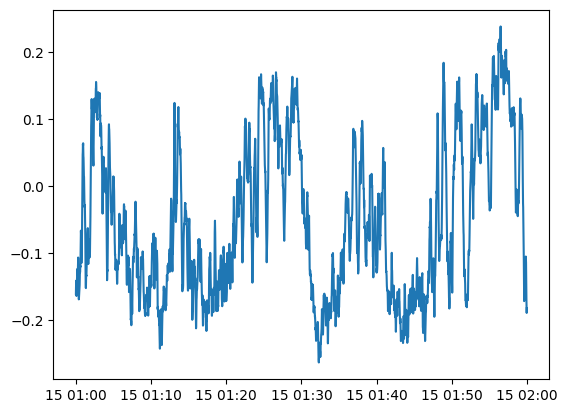

In [11]:
# Plot the omega data (ONE DAY)
plt.plot(valid_hours['omega'][0:3600])

In [6]:
def integrate_data(data, dt=1):
    integrated_data = np.zeros(len(data))
    for i in range(1, len(data)):
        integrated_data[i] = integrated_data[i-1] + data[i] * dt 
    return integrated_data


In [12]:
from scipy.integrate import cumtrapz

def integrate_data(omega_data, dt=1, initial_theta=0):
    theta_data = cumtrapz(omega_data, dx=dt, initial=initial_theta)
    return theta_data

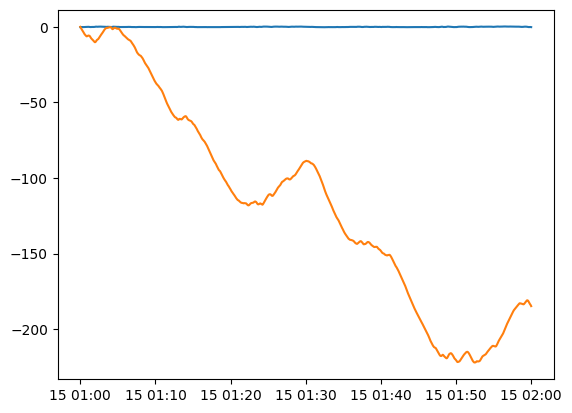

In [13]:
# Integrate the omega data and call it theta and add 'theta' column
valid_hours['theta'] = integrate_data(valid_hours['omega'],1)
# Plot the omega and theta data (ONE DAY)
plt.plot(valid_hours['omega'][0:3600])
plt.plot(valid_hours['theta'][0:3600])

In [14]:
import pandas as pd
from scipy.ndimage import gaussian_filter1d

def apply_gaussian_filter(data, region_name, chunk_size=900*4, sigma=60):
    # Create DataFrame
    data_df = pd.DataFrame({'omega': data})

    # Define the list to hold the filtered DataFrames
    filtered_data = []

    # Calculate the number of chunks needed
    num_chunks = len(data_df) // chunk_size

    # Split the DataFrame into chunks and apply the Gaussian filter to each chunk
    for j in range(num_chunks):
        # Extract the chunk
        chunk = data_df.iloc[j*chunk_size:(j+1)*chunk_size].copy()
        
        # Apply Gaussian filter to the 'omega' column
        chunk['omega_filtered'] = gaussian_filter1d(chunk['omega'], sigma=sigma)
        
        # Label the chunk with the specified region name
        chunk['Region'] = region_name
        
        # Append the filtered chunk to the list
        filtered_data.append(chunk)

    # If there are remaining data points
    if len(data_df) % chunk_size != 0:
        remaining_chunk = data_df.iloc[num_chunks*chunk_size:].copy()
        remaining_chunk['omega_filtered'] = gaussian_filter1d(remaining_chunk['omega'], sigma=sigma)
        
        # Label the remaining chunk with the specified region name
        remaining_chunk['Region'] = region_name
        
        # Append the remaining chunk to the list
        filtered_data.append(remaining_chunk)
    
    return filtered_data

In [15]:
# Apply Gaussian filter to the omega data
filtered_data = apply_gaussian_filter(valid_hours['omega'], 'South Korea')

# Check the number of chunks created
print(f"Number of chunks created: {len(filtered_data)}")
filtered_data

Number of chunks created: 2451


[                        omega  omega_filtered       Region
 2024-08-15 01:00:00 -0.160393       -0.086092  South Korea
 2024-08-15 01:00:01 -0.152990       -0.086075  South Korea
 2024-08-15 01:00:02 -0.140874       -0.086040  South Korea
 2024-08-15 01:00:03 -0.148052       -0.085989  South Korea
 2024-08-15 01:00:04 -0.157216       -0.085920  South Korea
 ...                       ...             ...          ...
 2024-08-15 01:59:55 -0.153148       -0.015374  South Korea
 2024-08-15 01:59:56 -0.168694       -0.015464  South Korea
 2024-08-15 01:59:57 -0.177234       -0.015531  South Korea
 2024-08-15 01:59:58 -0.188864       -0.015576  South Korea
 2024-08-15 01:59:59 -0.181731       -0.015599  South Korea
 
 [3600 rows x 3 columns],
                         omega  omega_filtered       Region
 2024-08-15 02:00:00 -0.170663       -0.021602  South Korea
 2024-08-15 02:00:01 -0.162034       -0.021608  South Korea
 2024-08-15 02:00:02 -0.148849       -0.021621  South Korea
 2024-08-15 

In [57]:
from sklearn.metrics import explained_variance_score, max_error

def calculate_model_scores(region_data, region_name, n=2):
    sindy_models = {}
    scores = {}

    transformations = {
        "linear_time": lambda chunk: np.arange(0, len(chunk), 1).reshape(-1, 1),
        "cumsum_omega": lambda chunk: np.cumsum(np.abs(chunk['omega_filtered'].values)).reshape(-1, 1),
        "cumsum_theta": lambda chunk: np.cumsum(np.abs(integrate_data(chunk['omega_filtered'].values))).reshape(-1, 1),
        "diff_omega": lambda chunk: np.insert(np.diff(chunk['omega_filtered'].values), 0, 0).reshape(-1, 1),
        "diff_theta": lambda chunk: np.insert(np.diff(integrate_data(chunk['omega_filtered'].values)), 0, 0).reshape(-1, 1),

        
        "log_time": lambda chunk: np.log1p((chunk.index - chunk.index[0]).total_seconds().to_numpy()).reshape(-1, 1),
        "squared_time": lambda chunk: ((chunk.index - chunk.index[0]).total_seconds().to_numpy() ** 2).reshape(-1, 1),
        "exp_time": lambda chunk: (np.exp((chunk.index - chunk.index[0]).total_seconds().to_numpy() / 1000) - 1).reshape(-1, 1),
    }

    for transform_name, transform_func in transformations.items():
        sindy_models[transform_name] = []
        scores[transform_name] = []

        for chunk in region_data:
            theta_chunk = integrate_data(chunk['omega_filtered'].values)
            stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega_filtered'].values))
            
            # Apply the selected time transformation
            t_train_chunk = transform_func(chunk)

            x_train_augmented_chunk = np.hstack([stacked_data_chunk, t_train_chunk])
            
            feature_names_chunk = ["theta", "omega", "time"]
            polynomial_library_chunk = ps.PolynomialLibrary(degree=n)
            sparse_regression_optimizer_chunk = ps.STLSQ(threshold=1e-10)
            
            model_chunk = ps.SINDy(feature_names=feature_names_chunk, 
                                   feature_library=polynomial_library_chunk,
                                   optimizer=sparse_regression_optimizer_chunk)
            
            model_chunk.fit(x_train_augmented_chunk, t=1)
            sindy_models[transform_name].append(model_chunk)
            
            # Compute the explained variance score
            score = model_chunk.score(x_train_augmented_chunk, t=1, metric=explained_variance_score)
            scores[transform_name].append(score)

        # Compute the mean score for this transformation
        mean_score = np.mean(scores[transform_name])
        print(f"Mean Model Score for {region_name} using {transform_name}: {mean_score}")

    return sindy_models, scores


In [69]:
sindy_models, scores = calculate_model_scores(filtered_data, 'South Korea', n=3)

Mean Model Score for South Korea using linear_time: 0.5526602393660828
Mean Model Score for South Korea using cumsum_omega: 0.8639266597834893
Mean Model Score for South Korea using cumsum_theta: 0.836276129532032
Mean Model Score for South Korea using diff_omega: 0.8444351195698483
Mean Model Score for South Korea using diff_theta: 0.9723534520717159
Mean Model Score for South Korea using log_time: 0.8826857677134612
Mean Model Score for South Korea using squared_time: 0.8097149114526753
Mean Model Score for South Korea using exp_time: 0.9014818954573988


In [70]:
linear_time_score = scores['linear_time']
cumsum_omega_score = scores['cumsum_omega']
cumsum_theta_score = scores['cumsum_theta']
diff_omega_score = scores['diff_omega']
diff_theta_score = scores['diff_theta']
log_time_score = scores['log_time']
squared_time_score = scores['squared_time']
exp_time_score = scores['exp_time']


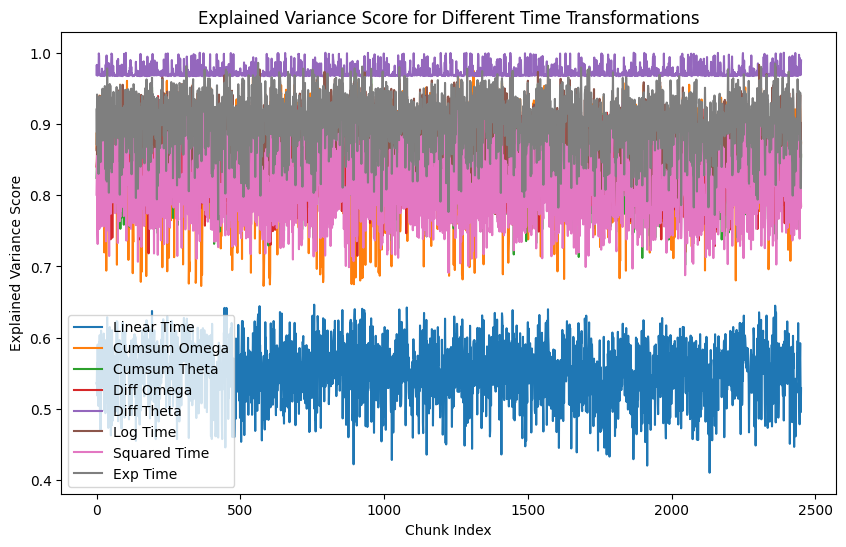

In [71]:
# Plot the scores
plt.figure(figsize=(10, 6))
plt.plot(linear_time_score, label='Linear Time')
plt.plot(cumsum_omega_score, label='Cumsum Omega')
plt.plot(cumsum_theta_score, label='Cumsum Theta')
plt.plot(diff_omega_score, label='Diff Omega')
plt.plot(diff_theta_score, label='Diff Theta')
plt.plot(log_time_score, label='Log Time')
plt.plot(squared_time_score, label='Squared Time')
plt.plot(exp_time_score, label='Exp Time')
plt.xlabel('Chunk Index')
plt.ylabel('Explained Variance Score')
plt.title('Explained Variance Score for Different Time Transformations')
plt.legend()
plt.show()


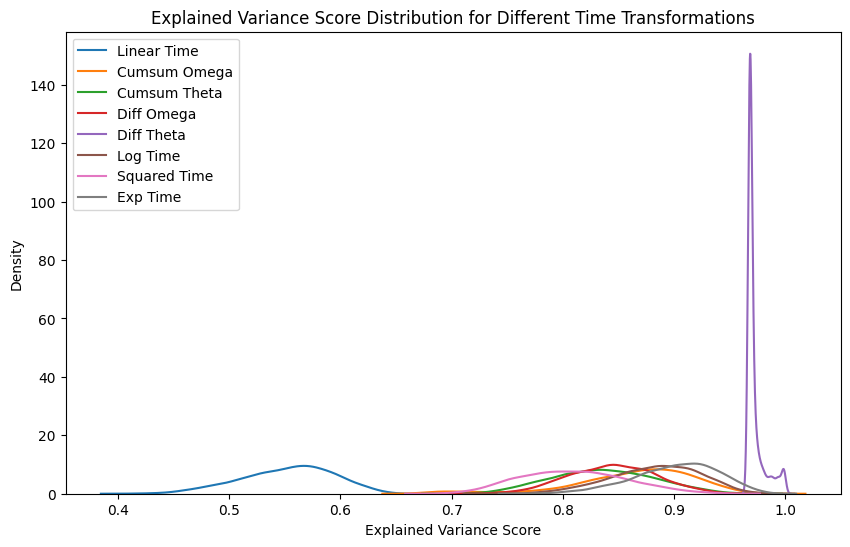

In [72]:
# plot the score with probability density function
plt.figure(figsize=(10, 6))
sns.kdeplot(linear_time_score, label='Linear Time')
sns.kdeplot(cumsum_omega_score, label='Cumsum Omega')
sns.kdeplot(cumsum_theta_score, label='Cumsum Theta')
sns.kdeplot(diff_omega_score, label='Diff Omega')
sns.kdeplot(diff_theta_score, label='Diff Theta')
sns.kdeplot(log_time_score, label='Log Time')
sns.kdeplot(squared_time_score, label='Squared Time')
sns.kdeplot(exp_time_score, label='Exp Time')
plt.xlabel('Explained Variance Score')
plt.ylabel('Density')
plt.title('Explained Variance Score Distribution for Different Time Transformations')
plt.legend()
plt.show()





In [63]:
# find out the maximum score and lowest score for each transformation
max_score = {}
min_score = {}
for key in scores.keys():
    max_score[key] = max(scores[key])
    min_score[key] = min(scores[key])

print("Maximum Scores for each transformation:")
print(max_score)
print("\nMinimum Scores for each transformation:")
print(min_score)

# find out the chunk index of the maximum score and lowest score for each transformation
max_score_index = {}
min_score_index = {}
for key in scores.keys():
    max_score_index[key] = scores[key].index(max_score[key])
    min_score_index[key] = scores[key].index(min_score[key])

print("Chunk Index of Maximum Scores for each transformation:")
print(max_score_index)
print("\nChunk Index of Minimum Scores for each transformation:")
print(min_score_index)






Maximum Scores for each transformation:
{'linear_time': 0.6372658119418781, 'cumsum_omega': 0.9393872070054066, 'cumsum_theta': 0.9354256498069663, 'diff_omega': 0.9419264713550177, 'diff_theta': 0.9999845924393119, 'log_time': 0.9337933229981799, 'squared_time': 0.9324026310469481, 'exp_time': 0.9687296054391852}

Minimum Scores for each transformation:
{'linear_time': 0.37519606400561134, 'cumsum_omega': 0.6702661838794542, 'cumsum_theta': 0.6736620754655682, 'diff_omega': 0.6903338309777604, 'diff_theta': 0.9667241298924085, 'log_time': 0.5919938272529918, 'squared_time': 0.669526345445203, 'exp_time': 0.7033157844610703}
Chunk Index of Maximum Scores for each transformation:
{'linear_time': 567, 'cumsum_omega': 933, 'cumsum_theta': 1410, 'diff_omega': 445, 'diff_theta': 1868, 'log_time': 1447, 'squared_time': 2305, 'exp_time': 955}

Chunk Index of Minimum Scores for each transformation:
{'linear_time': 894, 'cumsum_omega': 581, 'cumsum_theta': 183, 'diff_omega': 342, 'diff_theta': 

In [29]:
low_scores = {
    "linear_time": [score for score in linear_time_score if score < 0.4],
    "cumsum_omega": [score for score in cumsum_omega_score if score < 0.7],
    "cumsum_theta": [score for score in cumsum_theta_score if score < 0.7],
    "log_time": [score for score in log_time_score if score < 0.7],
    "squared_time": [score for score in squared_time_score if score < 0.7],
    "exp_time": [score for score in exp_time_score if score < 0.8],
}

# Print only the transformations for all scores
for key, values in low_scores.items():
    if values:
        print(f"{key}: {values}") # Print only the transformations that have low scores
        print(f"Number of low scores for {key}: {len(values)}") # Print the number of low scores in each transformation
        print(f"Lowest score for {key}: {min(values)}", f"Highest score: {max(values)}") # Find the  lowwest score in each transformation
        #print(f"Highest score for {key}: {max(values)}") # find the  highest score in each transformation
        print()


linear_time: [0.3849114324353538, 0.3967287431460244, 0.383566320393546, 0.39831782369743546, 0.39524815836038957, 0.39632920531948296, 0.39489566732396614, 0.3870912029674954, 0.3773605501140833, 0.3994486627451989, 0.39223403246431193, 0.39697542509943656, 0.37519606400561134, 0.39871837655337955, 0.39723795652407157, 0.3791647766087393, 0.39968382673830627, 0.37586439314589787, 0.39533314978946876, 0.3911816173123522, 0.39804750888992996, 0.3852632380256238, 0.38490482665536346, 0.39183769260617024, 0.3851884978282105, 0.39985163006337593, 0.39089462307892475, 0.3899926073779561, 0.39484120465991585, 0.3916718979359273, 0.39995078463271505, 0.39563174489289404, 0.38975525216428664, 0.3873929962818507, 0.39075526077110806, 0.39317768411795395, 0.39343045856400777, 0.3991584809151036, 0.3945096350573392, 0.3865775167217369, 0.39842789182261207]
Number of low scores for linear_time: 41
Lowest score for linear_time: 0.37519606400561134 Highest score: 0.39995078463271505

cumsum_omega: [

In [36]:
def simulate_sindy_model(model, initial_conditions, time_points, title, omega_original, omega_filtered):
    # Simulate the system using the provided model
    simulated_data = model.simulate(initial_conditions, time_points)

    # Extract simulated theta and omega
    simulated_theta = simulated_data[:, 0]
    simulated_omega = simulated_data[:, 1]

    # Plot the simulation results
    plt.figure(figsize=(10, 6))

    # Plot the original Omega with noise
    plt.plot(omega_original, label='Original Omega with noise', alpha=0.7, color='#2b6a99')

    # Plot the Gaussian Filtered Omega
    plt.plot(omega_filtered, label='Gaussian Filtered Omega', linestyle='-', linewidth=2, color='#1b7c3d')

    # Plot the simulated Omega
    plt.plot(simulated_omega, label='Simulated Omega', linestyle='--', linewidth=3, color='#f16c23')

    plt.title(f'Comparison of Original, Filtered, and Simulated Omega - {title}')
    plt.xlabel('Time')
    plt.ylabel('Omega')
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

In [ ]:
sindy_models['diff_omega']

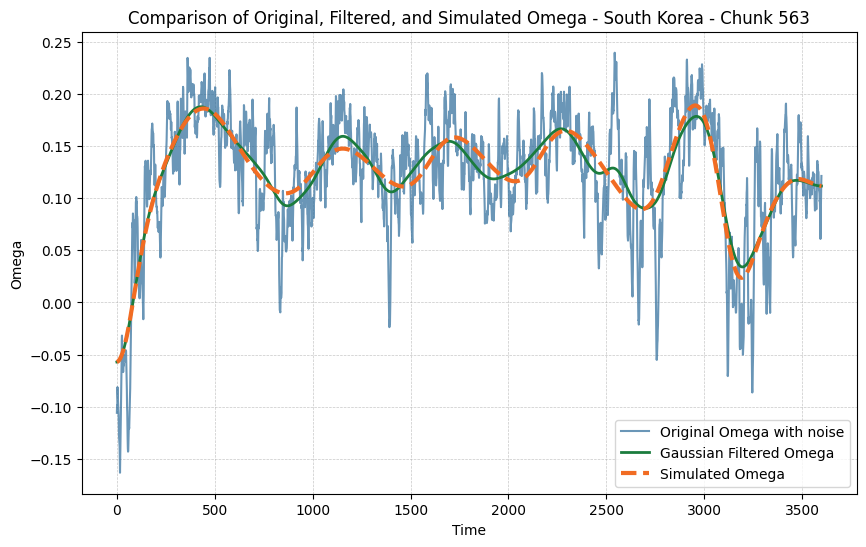

In [73]:
n = 562
initial_conditions = [integrate_data(filtered_data[n]['omega_filtered'].values)[0], 
                      filtered_data[n]['omega_filtered'].iloc[0], 0]

# Define time points for simulation
total_time = len(filtered_data[n]['omega_filtered'])
time_points = np.arange(0, total_time, 1)

# Assuming omega_original and omega_filtered are available
omega_original = filtered_data[n]['omega'].values  
omega_filtered = filtered_data[n]['omega_filtered'].values

# Simulate and plot results for a specific chunk (e.g., chunk 17)
simulate_sindy_model(sindy_models['exp_time'][n], initial_conditions, time_points, f'South Korea - Chunk {n+1}', omega_original, omega_filtered)

In [24]:
def plot_coefficients_for_regions(region_data, feature_names):
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    
    markers = ['o', 's', '^']
    region_names = list(region_data.keys())
    n_regions = len(region_names)
    bar_width = 0.2  # Width of space to allocate to each region's marker

    # Calculate the total width occupied by all the regions' markers
    total_width = bar_width * n_regions

    # Calculate the offset to center the feature names
    center_offset = total_width / 2 - bar_width / 2

    region_colors = {'South Korea': '#1b9e77'}

    for region_name, data in region_data.items():
        means, stds = data['means'], data['stds']
        n_features = means.shape[1]
        
        # Select the marker for the region
        marker = markers[region_names.index(region_name) % len(markers)]
        region_offset = bar_width * region_names.index(region_name)

        for i in range(n_features):
            # Apply offset for each region to center the markers
            ax.errorbar(i + region_offset, np.abs(means[1, i]), yerr=stds[1, i], fmt=marker, label=region_name if i == 0 else "", color=region_colors[region_name])

    ax.legend(fontsize=16, title_fontsize=16, frameon=False)
    ax.set_xticks(np.arange(n_features) + center_offset)
    ax.set_xticklabels(feature_names, fontsize=16)
    ax.set_ylabel("Coefficient Value", fontsize=16)
    ax.set_xlabel("Feature Candidates", fontsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_title("Coefficients with Error Bars for South Korea", fontsize=20)
    
    ax.set_yscale('log')
    ax.grid(axis='y', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    
    return ax  # Return the ax object

<Axes: title={'center': 'Coefficients with Error Bars for South Korea'}, xlabel='Feature Candidates', ylabel='Coefficient Value'>

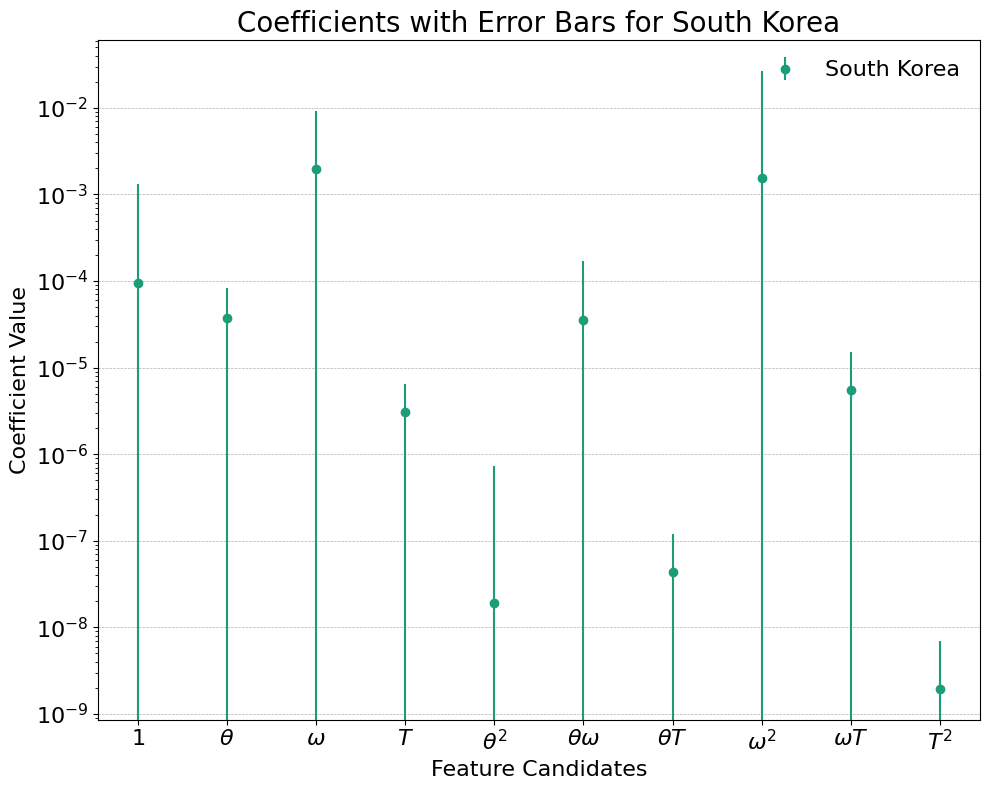

In [26]:
feature_names = ['$1$', r'$\theta$', r'$\omega$', r'$T$', 
                r'$\theta^2$', r'$\theta\omega$', r'$\theta T$', r'$\omega^2$', 
                r'$\omega T$',r'$T^2$']
#apply plot_coefficients_for_regions function for South Korea
plot_coefficients_for_regions({'South Korea': {'means': skmean, 'stds': skstd}}, feature_names)